In [6]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from project_resources.import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import isz_csv_data_formatting, fp_from_smiles, mol_predict_and_std, tanimoto, create_scatter_plot

In [18]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
isozymes = ["3A4", "RLM", "HLC"]
data_splits = ["train", "test"]
rel_paths = {
    "3A4_source": r"project_resources/ChEMBL_3A4.csv",
    "3A4_sep": ";",
    "3A4": r"project_resources/3A4.csv",
    "3A4_train_scaff": r"project_resources/data_splits/scaffold_splitter/3A4_train.csv",
    "3A4_test_scaff": r"project_resources/data_splits/scaffold_splitter/3A4_test.csv",
    "3A4_train_rand": r"project_resources/data_splits/random/3A4_train.csv",
    "3A4_test_rand": r"project_resources/data_splits/random/3A4_test.csv",

    "RLM_source": r"project_resources/AID_1508591_datatable_all.csv",
    "RLM_sep": ",",
    "RLM": r"project_resources/RLM.csv",
    "RLM_train_scaff": r"project_resources/data_splits/scaffold_splitter/RLM_train.csv",
    "RLM_test_scaff": r"project_resources/data_splits/scaffold_splitter/RLM_test.csv",
    "RLM_train_rand": r"project_resources/data_splits/random/RLM_train.csv",
    "RLM_test_rand": r"project_resources/data_splits/random/RLM_test.csv",


    "HLC_source": r"project_resources/AID_1508603_datatable_all.csv",
    "HLC_sep": ",",
    "HLC": r"project_resources/HLC.csv",
    "HLC_train_scaff": r"project_resources/data_splits/scaffold_splitter/HLC_train.csv",
    "HLC_test_scaff": r"project_resources/data_splits/scaffold_splitter/HLC_test.csv",
    "HLC_train_rand": r"project_resources/data_splits/random/HLC_train.csv",
    "HLC_test_rand": r"project_resources/data_splits/random/HLC_test.csv"
}
smiles = {}
fingerprints = {}
fp_arrays = {}
scaff_split_smiles = {}  # structure: {isozyme: [x_train, x_test, y_train, y_test]...}
scaff_split_halflives = {}
rand_split_smiles = {}
rand_split_halflives = {}
tanimoto_sims = {}
y_test_avg_predictions = {}
stds = {}
rmsds = {}
best_models = {}

In [19]:
for isozyme in isozymes:
    isz_csv_data_formatting(rel_paths[f"{isozyme}_source"], isozyme, sep=rel_paths[f"{isozyme}_sep"])
    df = pd.read_csv(rel_paths[isozyme])
    smiles[isozyme] = df["smiles"]
    print(f"{isozyme, list(smiles[isozyme][:10])}\n")

3A4.csv already exists in dir
('3A4', ['COc1ccc2[nH]cc(CCNC(C)=O)c2c1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3nnc(Cc4ccc(F)cc4F)cc32)[C@@H](CN2Cc3c(F)cccc3C2=O)CN1', 'O=c1[nH]c2ccccc2n1C1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc([C@@H](O)c4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2Cc3ccccc3C2=O)CN1', 'CCC(=O)NCC[C@@H]1CCc2ccc3c(c21)CCO3', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', 'CC(C)O[P@@]1(=O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@@]3(CCO3)[C@@H]2O1', 'CCS(=O)(=O)c1ccc2oc(-c3ccc4ccccc4c3)nc2c1'])

RLM.csv already exists in dir
('RLM', ['CCCCOC1=CC=C(C=C1)CC(=O)NO', 'COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC', 'COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3=CC=CO3', 'CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N', 'CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4)C5CCCCC5', 'CC1=C(C=C(C=C1)NS(=O)(=O)

In [20]:
# load train-test
for isozyme in isozymes:
    scaff_split_smiles[isozyme] = {}
    scaff_split_halflives[isozyme] = {}

    for data_split in data_splits:
        # load smiles
        split_df = pd.read_csv(rel_paths[f"{isozyme}_{data_split}_scaff"])
        split_smi = np.array(split_df["smiles"])
        scaff_split_smiles[isozyme][data_split] = split_smi

        # load half-life
        split_df = pd.read_csv(rel_paths[f"{isozyme}_{data_split}_scaff"])
        split_halflife = np.log(np.array(split_df["half-life"]))
        scaff_split_halflives[isozyme][data_split] = split_halflife

    print(f"""{isozyme}
x_train: {scaff_split_smiles[isozyme]["train"][:2]}
x_test: {scaff_split_smiles[isozyme]["test"][:2]}
y_train: {scaff_split_halflives[isozyme]["train"][:2]}
y_test: {scaff_split_halflives[isozyme]["test"][:2]}
""")

3A4
x_train: ['COc1cccc([C@@H](CO)NC(=O)[C@@H](C)N2Cc3ccc(-c4nc(NC5CCOCC5)ncc4Cl)cc3C2=O)c1'
 'COc1cc(F)cc([C@H](NC(=O)CN2Cc3ccc(-c4nc(NC5CCOCC5)ncc4Cl)cc3C2=O)C(C)O)c1']
x_test: ['O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCNC(=O)c4ccc5c(c4)nc(Nc4cccc(Cl)c4)c4ccncc45)c3C2=O)C(=O)N1'
 'O=C(CCCN1CCC(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F)cc1']
y_train: [-2.38956011 -2.48494665]
y_test: [-1.41346003 -2.90042209]

RLM
x_train: ['CS(=O)(=O)C1=CC=CC=C1C2=CSC(=N2)N3CCC(CC3)C(=O)N'
 'C1CN(CCC1C(=O)N)C2=NC(=CS2)C3=CC(=CC=C3)N']
x_test: ['CN1C2=C(C=C(C=C2)S(=O)(=O)N(C)C)C=C1C(=O)NCCCOC'
 'C1CCC(CC1)C(=O)NC2=CC=CC=C2C(=O)NC3=CC=CC(=C3)C(F)(F)F']
y_train: [3.40119738 3.40119738]
y_test: [3.21887582 3.21887582]

HLC
x_train: ['CC1=C(C=CC(=C1)F)OC2CN(C2)CC3=CC=C(C=C3)C#N'
 'CC1=C(C=CC(=C1)OC2CN(C2)CC3=CC=C(C=C3)C#N)F']
x_test: ['C1COC[C@H](N1CC2=CN=CN2)C3=NC=C(N3)C4=CC(=CC=C4)F'
 'C1COC[C@H](N1CC2=CN=CN2)C3=NC=C(N3)C4=CC=CC=C4']
y_train: [3.56671182 3.77963382]
y_test: [4.08260931 4.78749174]



In [10]:
# convert smiles from every isozyme and split to Morgan fingerprint as numpy array
for isozyme in isozymes:
    fp_arrays[isozyme] = {}
    for data_split in data_splits:
        fps = fp_from_smiles(scaff_split_smiles[isozyme][data_split])
        fp_arrays[isozyme][data_split] = np.array(fps)
    print(fps[0])

[0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1
 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0
 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0
 1 1 0 0 1 1 1 0 1 1 1 1 0]
[0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0
 1 1 0 0 0 1 0 0 0 1 0 1 1]
[0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1
 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [11]:
for isozyme in isozymes:
    x_train = fp_arrays[isozyme]["train"]
    x_test = fp_arrays[isozyme]["test"]
    y_train = scaff_split_halflives[isozyme]["train"]
    y_test = scaff_split_halflives[isozyme]["test"]
    print(isozyme)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    y_test_avg_predict, std, rmsd = mol_predict_and_std(models, x_train, x_test, y_train, y_test)
    y_test_avg_predictions[isozyme] = y_test_avg_predict
    stds[isozyme] = std
    rmsds[isozyme] = rmsd
    print(f"     root-mean-square deviations: {rmsds[isozyme]}\n")

3A4
(56, 124) (56,) (14, 124) (14,)
     best linear hyperparams: ElasticNet(alpha=0.01)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0.9)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0)
     best KRR hyperparams: KernelRidge(alpha=1.623776739188721, gamma=0.03359818286283774,
            kernel='laplacian')
     best KRR hyperparams: KernelRidge(alpha=5.455594781168514, gamma=1.0)
     best KRR hyperparams: KernelRidge(alpha=0.0011288378916846883, gamma=3.792690190732238e-05,
            kernel='rbf')
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=200)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=10)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, n_estimators=10)
     best RF hyperparams: RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=20)


KeyboardInterrupt: 

In [12]:
for isozyme in isozymes:
    isozyme_rmsds = list(rmsds[isozyme].values())
    lowest_rmsd = min(isozyme_rmsds)
    best_model_for_isozyme = list(rmsds[isozyme].keys())[list(rmsds[isozyme].values()).index(lowest_rmsd)]
    best_models[isozyme] = best_model_for_isozyme
    print(f"best model for {isozyme}: {best_model_for_isozyme} with rmsd {lowest_rmsd}")

KeyError: '3A4'

In [13]:
for isozyme in isozymes:
    tanimoto_similarities = tanimoto(fp_arrays[isozyme]["test"], fp_arrays[isozyme]["train"])
    tanimoto_sims[isozyme] = tanimoto_similarities

[0.649, 0.62, 0.509, 0.81, 0.5, 0.828, 0.833, 0.368, 0.5, 0.623, 0.368, 0.914, 0.681, 0.375] length: 14
[0.508, 0.683, 0.574, 0.556, 0.531, 0.538, 0.974, 0.556, 0.87, 0.773, 0.517, 0.484, 0.518, 0.755, 0.683, 0.795, 0.83, 0.554, 0.825, 0.526, 0.603, 0.479, 0.757, 0.574, 0.569] length: 507
[0.686, 0.653, 0.5, 0.531, 0.561, 0.586, 0.444, 0.422, 0.533, 0.511, 0.654, 0.596, 0.519, 0.483, 0.744, 0.739, 0.809, 0.812, 0.635, 0.565, 0.455, 0.357, 0.717, 0.675, 0.8] length: 38


In [14]:
for isozyme in isozymes:
    model = best_models[isozyme]
    create_scatter_plot(tanimoto_sims[isozyme], y_test_avg_predictions[isozyme][model], model, "tanimoto similarities", "abs error")

KeyError: '3A4'

In [15]:
for isozyme in isozymes:
    model = best_models[isozyme]
    plt.clf()
    plt.errorbar(y_test_avg_predictions[isozyme][model], scaff_split_halflives[isozyme]["test"], yerr=stds[isozyme][model], linewidth=1, capsize=2, fmt='o')
    plt.xlabel('molecule error')
    plt.ylabel('y test')
    plt.suptitle(f"{isozyme, model}")
    plt.show()

KeyError: '3A4'

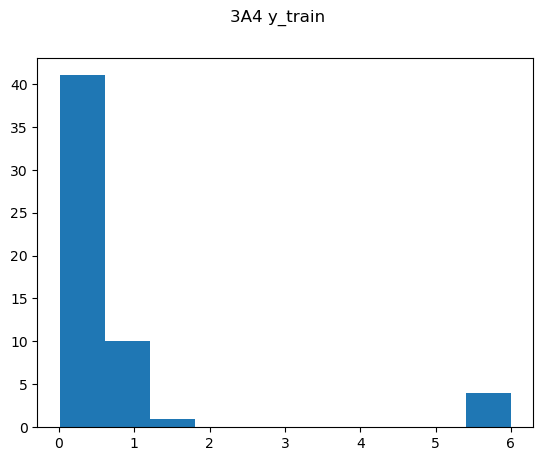

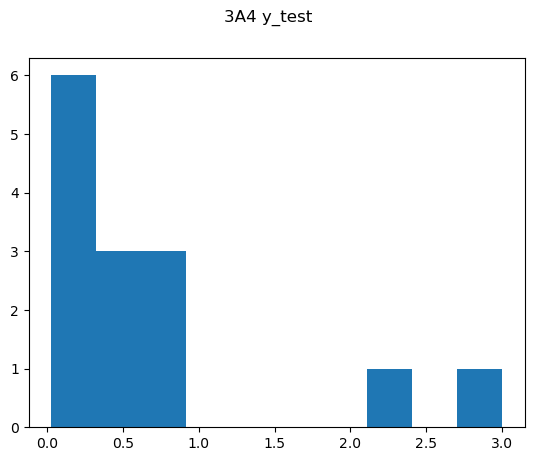

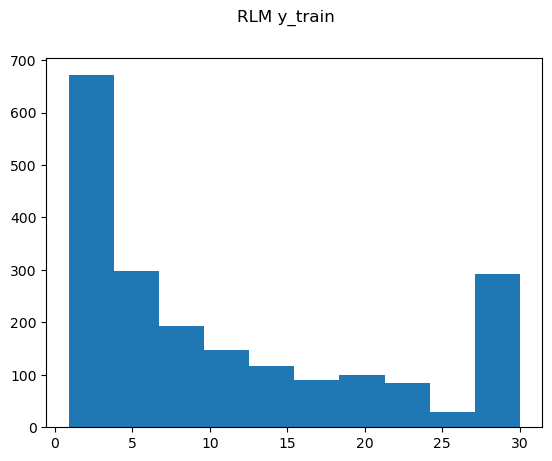

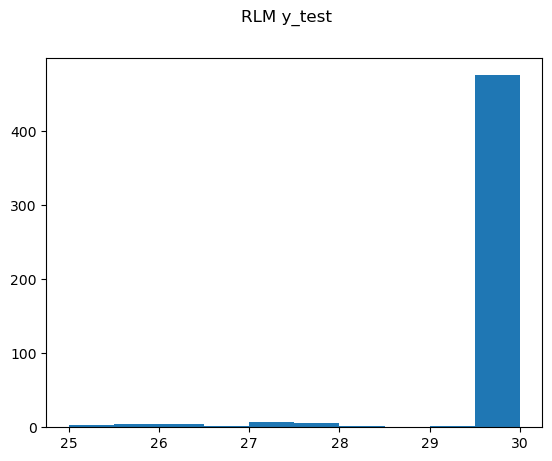

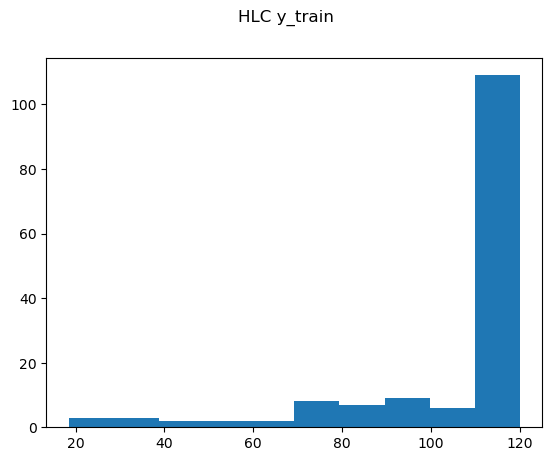

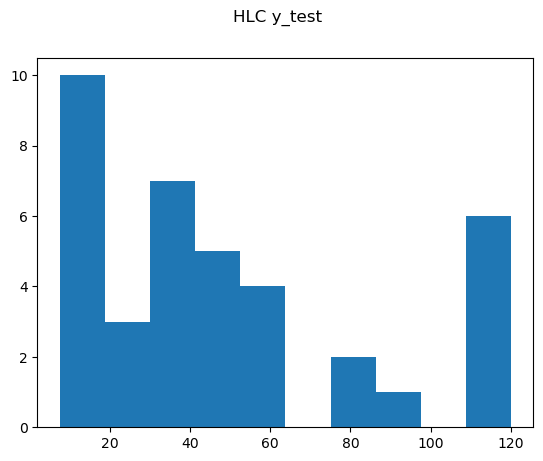

In [16]:
for isozyme in isozymes:
    for split in data_splits:
        y_split = np.exp(scaff_split_halflives[isozyme][split])
        plt.hist(y_split)
        plt.suptitle(f"{isozyme} y_{split}")
        plt.show()

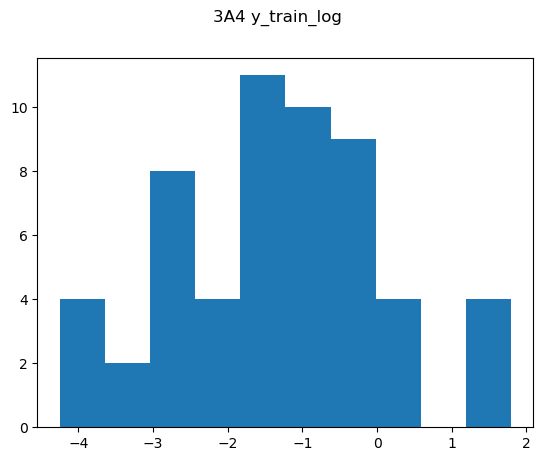

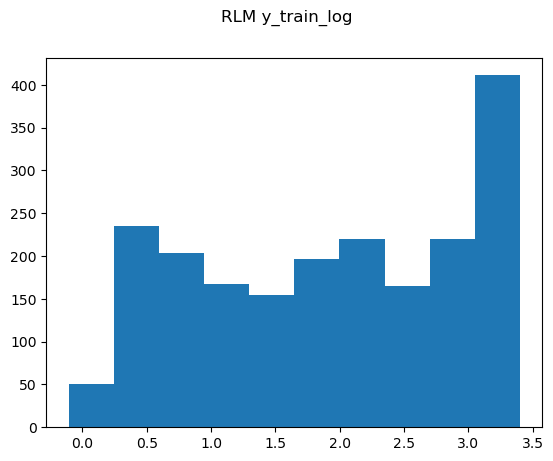

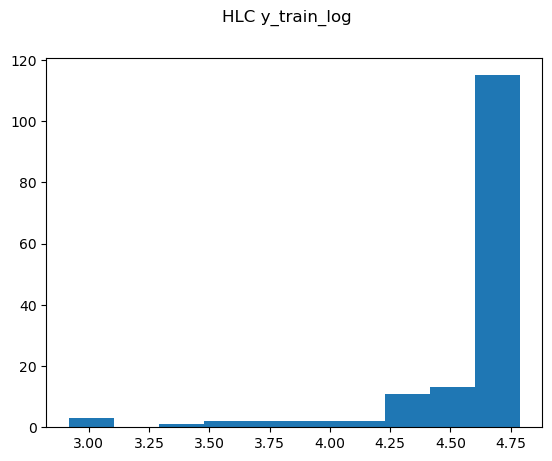

In [17]:
for isozyme in isozymes:
    y_train_log = scaff_split_halflives[isozyme]["train"]
    plt.hist(y_train_log)
    plt.suptitle(f"{isozyme} y_train_log")
    plt.show()